# Bibliotecas

In [104]:
import pandas as pd
import numpy as np
from zlib import crc32
from pandas.plotting import scatter_matrix
from scipy import stats

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Importar Dados

In [2]:
df = pd.read_csv('data/housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Analise do Dataframe

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [5]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


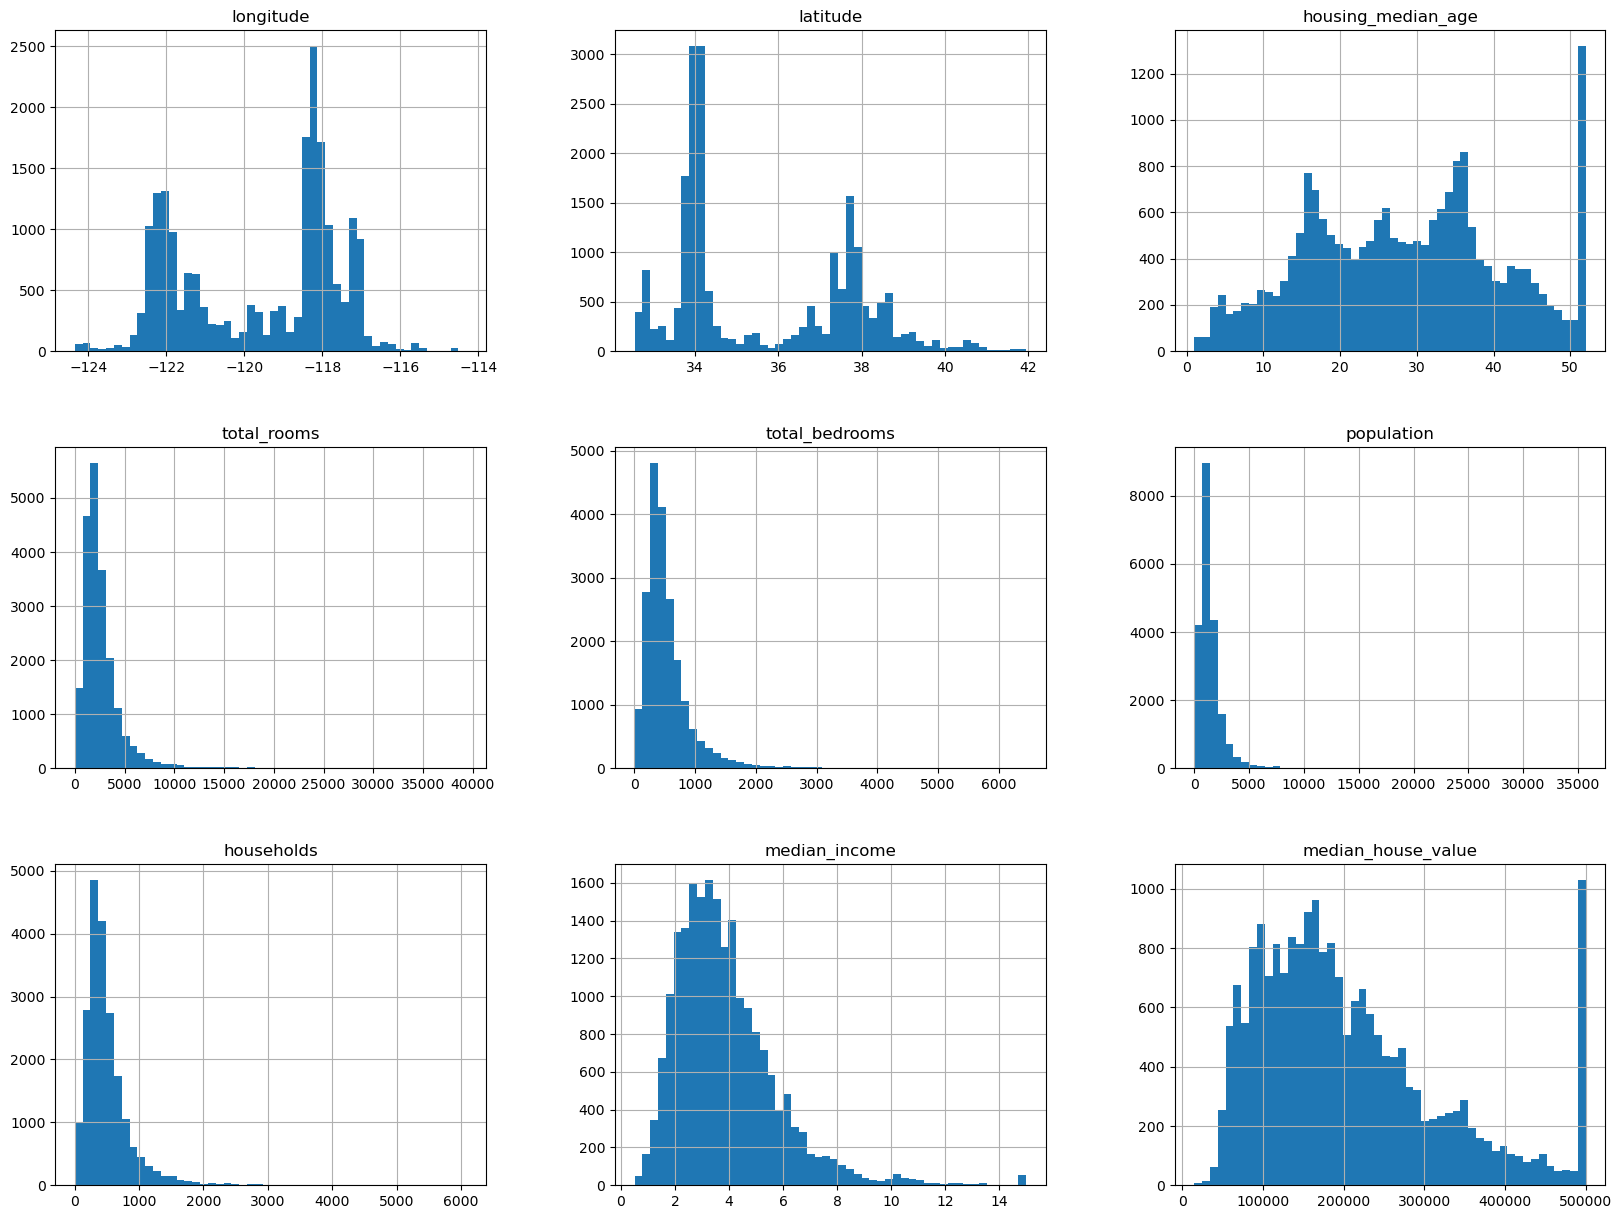

In [6]:
df.hist(bins=50, figsize=(20, 15))
plt.show()

# Criando um Conjunto de Teste

In [7]:
def split_train_teste(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [8]:
train_set, test_set = split_train_teste(df, 0.2)

In [9]:
train_set.shape, test_set.shape

((16512, 10), (4128, 10))

## Garantir que os dados de teste e treino sejam sempre os mesmos

In [10]:
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [11]:
df_with_id = df.reset_index()
df_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [12]:
train_set, test_set = split_train_test_by_id(df_with_id, 0.2, 'index')

## Usando o Scikit-Learn

In [13]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [14]:
train_set.shape, test_set.shape

((16512, 10), (4128, 10))

## Criar categoria para a renda

In [15]:
df['income_cat'] = pd.cut(df['median_income'], 
                          bins=[0., 1.5, 3.0, 4.5, 6., np.inf], 
                          labels=[1, 2, 3, 4, 5])

<Axes: >

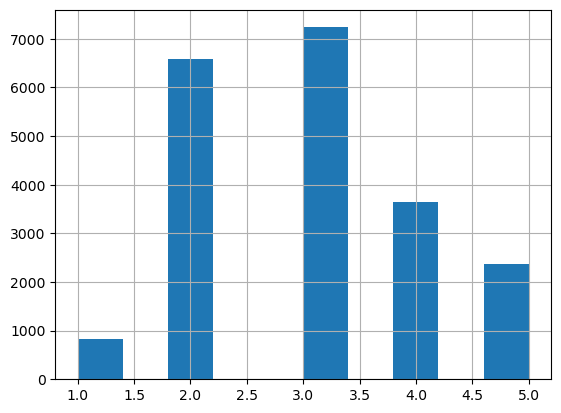

In [16]:
df['income_cat'].hist()

## Usando o Scikit-Learn para criar amostragem estratificada

In [17]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df['income_cat']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [18]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [19]:
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

income_cat
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: count, dtype: float64

In [20]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

# Visualização de Dados

## Visualização de Dados Geográficos

In [21]:
df = strat_test_set.copy()
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,500001.0,<1H OCEAN
17352,-120.42,34.89,24.0,2020.0,307.0,855.0,283.0,5.0099,162500.0,<1H OCEAN
3505,-118.45,34.25,36.0,1453.0,270.0,808.0,275.0,4.3839,204600.0,<1H OCEAN
7777,-118.10,33.91,35.0,1653.0,325.0,1072.0,301.0,3.2708,159700.0,<1H OCEAN
14155,-117.07,32.77,38.0,3779.0,614.0,1495.0,614.0,4.3529,184000.0,NEAR OCEAN


<Axes: xlabel='longitude', ylabel='latitude'>

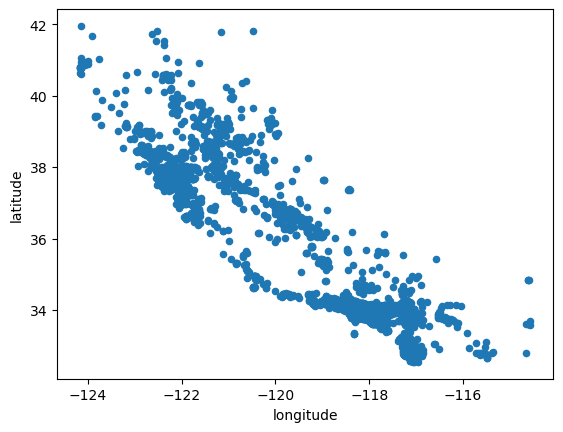

In [22]:
df.plot(kind='scatter', x='longitude', y='latitude')

<Axes: xlabel='longitude', ylabel='latitude'>

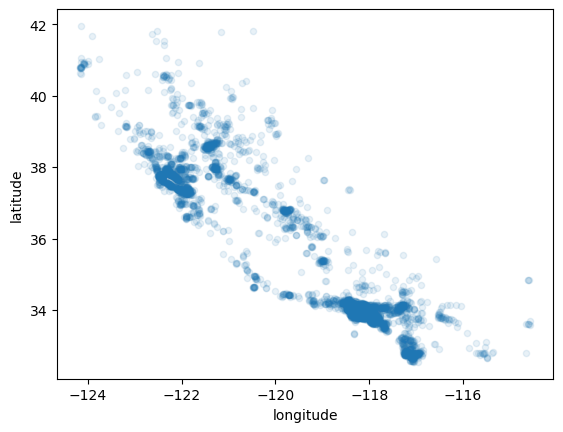

In [23]:
df.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

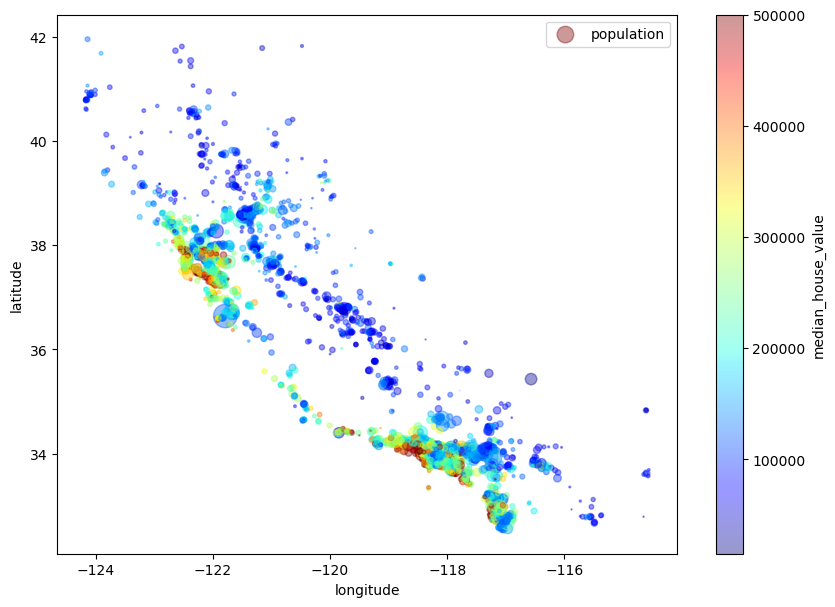

In [24]:
df.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, 
        s=df['population']/100, label='population', 
        figsize=(10, 7),
       c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()

## Buscando Correlações 

In [25]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.925426,-0.117560,0.028628,0.043930,0.068887,0.026334,0.002910,-0.039848
latitude,-0.925426,1.000000,0.032850,-0.024331,-0.046573,-0.084358,-0.045920,-0.099023,-0.150336
housing_median_age,-0.117560,0.032850,1.000000,-0.350487,-0.304722,-0.287470,-0.290560,-0.150288,0.071210
total_rooms,0.028628,-0.024331,-0.350487,1.000000,0.933630,0.864091,0.918768,0.191623,0.131296
total_bedrooms,0.043930,-0.046573,-0.304722,0.933630,1.000000,0.882700,0.978303,-0.000252,0.057247
population,0.068887,-0.084358,-0.287470,0.864091,0.882700,1.000000,0.916104,0.014239,-0.016164
households,0.026334,-0.045920,-0.290560,0.918768,0.978303,0.916104,1.000000,0.021517,0.070947
median_income,0.002910,-0.099023,-0.150288,0.191623,-0.000252,0.014239,0.021517,1.000000,0.691867
median_house_value,-0.039848,-0.150336,0.071210,0.131296,0.057247,-0.016164,0.070947,0.691867,1.000000


In [26]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.691867
total_rooms           0.131296
housing_median_age    0.071210
households            0.070947
total_bedrooms        0.057247
population           -0.016164
longitude            -0.039848
latitude             -0.150336
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

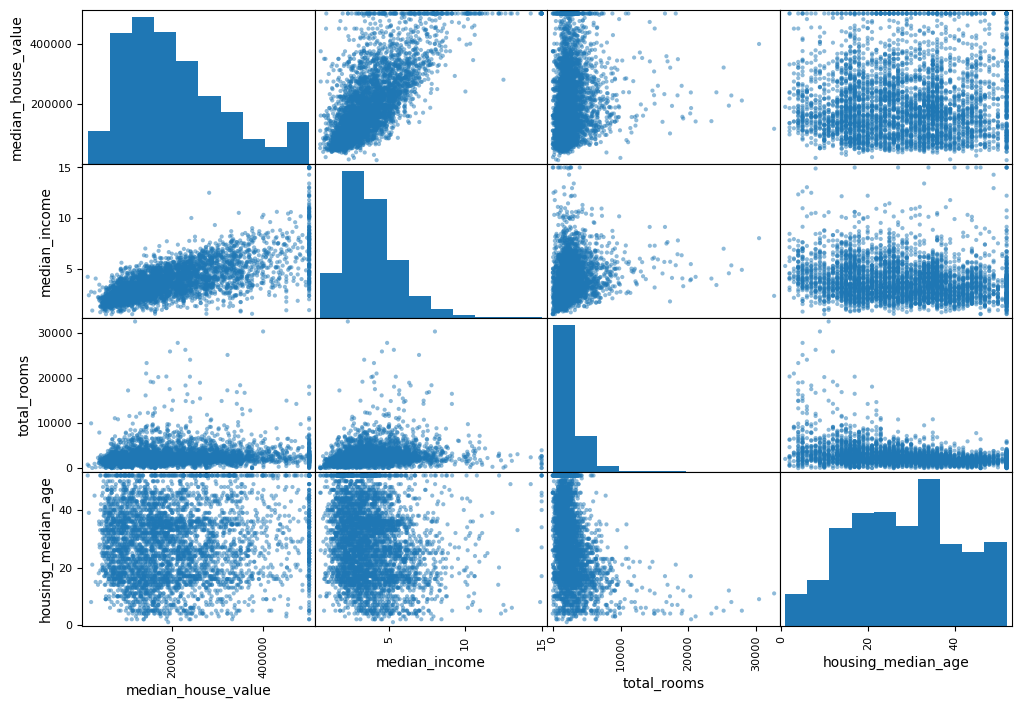

In [27]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(df[attributes], figsize=(12, 8))

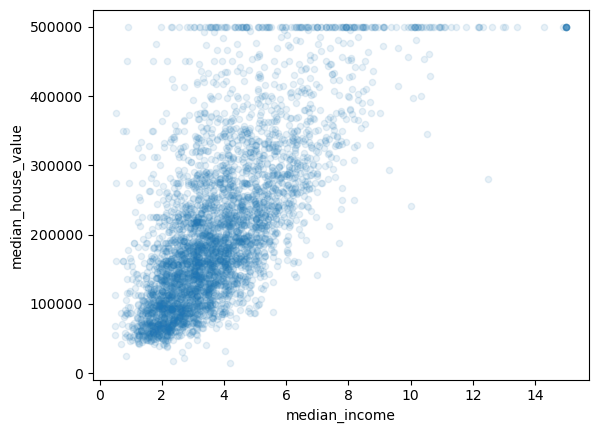

In [28]:
# median_income é o atributo mais promissor para preer o valor médio dos imóvveis

df.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)
plt.show()

## Testando Combinações de Atributos

In [29]:
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population'] / df['households']

In [30]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,500001.0,<1H OCEAN,6.715625,0.156972,2.275000
17352,-120.42,34.89,24.0,2020.0,307.0,855.0,283.0,5.0099,162500.0,<1H OCEAN,7.137809,0.151980,3.021201
3505,-118.45,34.25,36.0,1453.0,270.0,808.0,275.0,4.3839,204600.0,<1H OCEAN,5.283636,0.185822,2.938182
7777,-118.10,33.91,35.0,1653.0,325.0,1072.0,301.0,3.2708,159700.0,<1H OCEAN,5.491694,0.196612,3.561462
14155,-117.07,32.77,38.0,3779.0,614.0,1495.0,614.0,4.3529,184000.0,NEAR OCEAN,6.154723,0.162477,2.434853


In [31]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
longitude,1.000000,-0.925426,-0.117560,0.028628,0.043930,0.068887,0.026334,0.002910,-0.039848,-0.023984,0.081280,0.093906
latitude,-0.925426,1.000000,0.032850,-0.024331,-0.046573,-0.084358,-0.045920,-0.099023,-0.150336,0.104396,-0.101795,-0.082750
housing_median_age,-0.117560,0.032850,1.000000,-0.350487,-0.304722,-0.287470,-0.290560,-0.150288,0.071210,-0.196945,0.133676,-0.007198
total_rooms,0.028628,-0.024331,-0.350487,1.000000,0.933630,0.864091,0.918768,0.191623,0.131296,0.178864,-0.171875,-0.086069
total_bedrooms,0.043930,-0.046573,-0.304722,0.933630,1.000000,0.882700,0.978303,-0.000252,0.057247,0.008359,0.074836,-0.106361
population,0.068887,-0.084358,-0.287470,0.864091,0.882700,1.000000,0.916104,0.014239,-0.016164,-0.064229,0.026499,0.089886
households,0.026334,-0.045920,-0.290560,0.918768,0.978303,0.916104,1.000000,0.021517,0.070947,-0.074018,0.057790,-0.098632
median_income,0.002910,-0.099023,-0.150288,0.191623,-0.000252,0.014239,0.021517,1.000000,0.691867,0.432782,-0.581852,-0.025842
median_house_value,-0.039848,-0.150336,0.071210,0.131296,0.057247,-0.016164,0.070947,0.691867,1.000000,0.192731,-0.240481,-0.134999
rooms_per_household,-0.023984,0.104396,-0.196945,0.178864,0.008359,-0.064229,-0.074018,0.432782,0.192731,1.000000,-0.547717,0.004859


In [32]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.691867
rooms_per_household         0.192731
total_rooms                 0.131296
housing_median_age          0.071210
households                  0.070947
total_bedrooms              0.057247
population                 -0.016164
longitude                  -0.039848
population_per_household   -0.134999
latitude                   -0.150336
bedrooms_per_room          -0.240481
Name: median_house_value, dtype: float64

# Preparar Dados para Algoritmos de ML

## Limpando Dados

In [33]:
df = strat_train_set.drop('median_house_value', axis=1)
df_labels = strat_train_set['median_house_value'].copy()

In [34]:
# Definir a média para os valores valores faltantes

imputer = SimpleImputer(strategy='median')

# Como a média é calculado apemas para atributos numéricos:
df_num = df.drop('ocean_proximity', axis=1)

# Imputar a média
imputer.fit(df_num)

SimpleImputer(strategy='median')

In [35]:
# Valores médios dos atributos
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [36]:
df_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [37]:
# Colocar os valores médios nos valores ausentes
X = imputer.transform(df_num)

In [38]:
# Colocando novamente no dataframe
df_tr = pd.DataFrame(X, columns=df_num.columns, index=df_num.index)
df_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


## Manipulando texto e atributos categóricos 

In [39]:
df_cat = df[["ocean_proximity"]]
df_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [40]:
# Transformar dados categóricos em numérico ordinal
ordinal_encoder = OrdinalEncoder()
df_cat_encoded = ordinal_encoder.fit_transform(df_cat)
df_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [41]:
# Categórias para cada atributo categórico
# 0 - <1h ocean
# 1 - inland
# 2 - island
# 3 - near bay
# 4 - near ocean

ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

A categoria 0 está mais próxima da 4 do que da 1. Isso torna o uso do OrdinalEncoder um problema, pois os algoritmos de ML tendem a assumir que valores próximos representam categorias semelhantes.

### One Hot Encoding

In [42]:
cat_encoder = OneHotEncoder()
df_cat_1hot = cat_encoder.fit_transform(df_cat)
df_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [43]:
# Transformar essa matriz esparsa em um array
df_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Customize os transformadores

In [44]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self # nothing else to do
        
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [45]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
df_extra_attribs = attr_adder.transform(df.values)

## Pipelines

In [46]:
num_pipelines = Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('attribs_adder',CombinedAttributesAdder()),
    ('std_scaler',StandardScaler()),
])

In [47]:
df_num_tr = num_pipelines.fit_transform(df_num)

In [48]:
num_attribs = list(df_num)
cat_attribs = ['ocean_proximity']

In [49]:
full_pipeline = ColumnTransformer([
    ('num', num_pipelines, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])

df_prepared = full_pipeline.fit_transform(df)

In [50]:
df_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

# Escolha e Treine um Modelo

## Regressão Linear

In [51]:
lin_reg = LinearRegression()
lin_reg.fit(df_prepared, df_labels)

LinearRegression()

In [52]:
some_data = df.iloc[:5]
some_labels = df_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print(f'Predicao: {lin_reg.predict(some_data_prepared)}')

Predicao: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]


In [53]:
print(f'Labels: {list(some_labels)}')

Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [54]:
df_predictions = lin_reg.predict(df_prepared)
lin_mse = mean_squared_error(df_labels, df_predictions)
lin_rmse = np.sqrt(lin_mse)

In [55]:
print(f'MSE: {round(lin_mse, 2)}\nRMSE: {round(lin_rmse, 2)}')

MSE: 4709785076.06
RMSE: 68627.87


## Árvore de Decisão

In [56]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(df_prepared, df_labels)

DecisionTreeRegressor()

In [57]:
df_predictions = tree_reg.predict(df_prepared)
tree_mse = mean_squared_error(df_labels, df_predictions)
tree_rmse = np.sqrt(tree_mse)

In [58]:
print(f'MSE: {round(tree_mse, 2)}\nRMSE: {round(tree_rmse, 2)}')

MSE: 0.0
RMSE: 0.0


## Validação Cruzada

In [59]:
# Validação Cruzada para Árvore de Decisão
scores = cross_val_score(tree_reg, df_prepared, df_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [60]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [61]:
display_scores(tree_rmse_scores)

Scores: [72523.03664762 69235.84552796 68414.62604398 71533.40334659
 71291.60007736 77261.27958906 72072.54574439 73592.35686466
 68171.99704707 70863.9715802 ]
Mean: 71496.06624688847
Standard deviation: 2551.7673808297814


In [62]:
# VValidação Cruzada para Regressão Linear
scores = cross_val_score(lin_reg, df_prepared, df_labels, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-scores)

In [63]:
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180634


## Floresta Aleatória

In [64]:
forest_reg = RandomForestRegressor()
forest_reg.fit(df_prepared, df_labels)

RandomForestRegressor()

In [65]:
df_predictions = forest_reg.predict(df_prepared)
forest_mse = mean_squared_error(df_labels, df_predictions)
fores_rmse = np.sqrt(tree_mse)

In [66]:
scores = cross_val_score(forest_reg, df_prepared,df_labels, scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-scores)

In [67]:
display_scores(forest_rmse_scores)

Scores: [51630.002847   48708.89817132 46616.21879401 51952.28505903
 47587.03728277 51673.06830998 52075.61127517 50010.75539552
 48724.54712796 54065.98014002]
Mean: 50304.4404402789
Standard deviation: 2230.408137870779


## Naive Bayes

In [68]:
naiveB_reg = GaussianNB()
naiveB_reg.fit(df_prepared, df_labels)

GaussianNB()

In [69]:
df_predictions = naiveB_reg.predict(df_prepared)
naiveB_mse = mean_squared_error(df_labels, df_predictions)
naiveB_rmse = np.sqrt(naiveB_mse)

In [70]:
scores = cross_val_score(naiveB_reg, df_prepared,df_labels, scoring='neg_mean_squared_error', cv=10)
naiveB_rmse_scores = np.sqrt(-scores)

C:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


In [71]:
display_scores(naiveB_rmse_scores)

Scores: [103228.28221864 101516.0338255  102433.73482803  99450.71875671
 105154.37596711 105041.16263417  96648.31874805  95072.27273274
 106336.00653617 103972.3511717 ]
Mean: 101885.32574188209
Standard deviation: 3561.2095756610556


## SVR

In [72]:
svr_reg = SVR()
svr_reg.fit(df_prepared, df_labels)

SVR()

In [73]:
df_predictions = svr_reg.predict(df_prepared)
svr_mse = mean_squared_error(df_labels, df_predictions)
svr_rmse = np.sqrt(svr_mse)

In [74]:
scores = cross_val_score(svr_reg, df_prepared,df_labels, scoring='neg_mean_squared_error', cv=10)
svr_rmse_scores = np.sqrt(-scores)

In [75]:
display_scores(svr_rmse_scores)

Scores: [116729.13778306 120113.99351281 113925.04340616 120399.11878641
 114687.49942071 122785.64737282 119853.79338279 118280.31108193
 120230.82615529 118840.1885232 ]
Mean: 118584.55594251942
Standard deviation: 2609.6120823493407


## KNN

In [76]:
knn_reg = KNeighborsRegressor()
knn_reg.fit(df_prepared, df_labels)

KNeighborsRegressor()

In [77]:
df_predictions = knn_reg.predict(df_prepared)
knn_mse = mean_squared_error(df_labels, df_predictions)
knn_rmse = np.sqrt(knn_mse)

In [78]:
scores = cross_val_score(knn_reg, df_prepared,df_labels, scoring='neg_mean_squared_error', cv=10)
knn_rmse_scores = np.sqrt(-scores)

In [79]:
display_scores(knn_rmse_scores)

Scores: [65167.64959479 59120.5900113  57331.5343357  66253.68599958
 59972.97479182 63185.90406458 62279.6050921  62747.9198944
 60440.20157013 65228.82974298]
Mean: 62172.8895097384
Standard deviation: 2773.5462809632822


## Salvando Modelos

# Aperfeiçoando os Modelos

## Grid Search

In [82]:
param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(df_prepared, df_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
# Melhores hiperparâmetros

grid_search.best_params_

In [84]:
param_grid = [
{'n_estimators': [30, 50, 70, 100], 'max_features': [8, 10, 12, 14]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(df_prepared, df_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [8, 10, 12, 14],
                          'n_estimators': [30, 50, 70, 100]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [85]:
# Melhores hiperparâmetros

grid_search.best_params_

{'max_features': 8, 'n_estimators': 70}

In [88]:
grid_search.best_score_

-2440163647.9553223

## Randomized Search

In [89]:
param_dist = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
forest_reg = RandomForestRegressor()
random_search = RandomizedSearchCV(estimator=forest_reg, param_distributions=param_dist, n_iter=10, cv=5, random_state=42,)
random_search.fit(df_prepared, df_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 100, 200]},
                   random_state=42)

In [90]:
# Melhores parametros
random_search.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': None,
 'bootstrap': True}

In [92]:
random_search.best_score_

0.8099007253418439

## Anlise os melhores modelos e seus erros

In [93]:
feature_importance = grid_search.best_estimator_.feature_importances_
feature_importance

array([6.96221700e-02, 6.32588450e-02, 4.30704114e-02, 1.49156572e-02,
       1.47047199e-02, 1.53825624e-02, 1.44454794e-02, 3.84261236e-01,
       4.81078103e-02, 1.10986285e-01, 5.73904245e-02, 7.11647173e-03,
       1.51448542e-01, 1.11074909e-04, 1.84615371e-03, 3.33215625e-03])

In [95]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importance, attributes), reverse=True)

[(0.38426123610503626, 'median_income'),
 (0.15144854188154525, 'INLAND'),
 (0.11098628529858572, 'pop_per_hhold'),
 (0.06962216995114007, 'longitude'),
 (0.06325884500296246, 'latitude'),
 (0.05739042453880179, 'bedrooms_per_room'),
 (0.0481078103197213, 'rooms_per_hhold'),
 (0.04307041138576537, 'housing_median_age'),
 (0.015382562363765735, 'population'),
 (0.014915657233726601, 'total_rooms'),
 (0.014704719932057101, 'total_bedrooms'),
 (0.014445479380820206, 'households'),
 (0.007116471728878394, '<1H OCEAN'),
 (0.003332156254532819, 'NEAR OCEAN'),
 (0.00184615371368647, 'NEAR BAY'),
 (0.00011107490897449767, 'ISLAND')]

## Avalie seu sistema no conjunto de testes

In [96]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

In [97]:
X_test_prepared = full_pipeline.transform(X_test)
final_prediction = final_model.predict(X_test_prepared)

In [99]:
final_mse = mean_squared_error(y_test, final_prediction)
final_rmse = np.sqrt(final_mse)

In [103]:
round(final_mse,2), round(final_rmse,2)

(2245608144.43, 47387.85)

In [106]:
confidence = 0.95
squared_errors = (final_prediction - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([45397.37635266, 49298.01729441])